In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os
import math
from scipy import stats
from straxen import units
from scipy.optimize import curve_fit
from datetime import datetime, timedelta
from scipy.interpolate import interp1d
from scipy.stats import beta, chi2

import peaks_utility as psu
import drift_diffusion_utility as ddu
import s2widthcut_utility as wcu

Start import
Working on midway2-0412.rcc.local with the following versions 
and installation paths:
strax
	v0.15.3	/dali/lgrandi/strax/strax/strax
straxen
	v0.18.8	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [3]:
dsets = st.select_runs(exclude_tags=('bad','messy','abandon','flash',
                                     'ramp down','hev test','_messy'),
                       run_mode='ambe_link',
                       available=('events','peak_basics'))

Checking data availability: 100%|██████████| 3/3 [02:28<00:00, 49.34s/it]


In [4]:
dsets = dsets[(dsets.end > pd.to_datetime('06/03/2021'))]

In [5]:
dsets

name number       mode                     end  \
845   021463  21463  ambe_link 2021-06-05 07:33:05.423   
847   021461  21461  ambe_link 2021-06-05 07:30:39.007   
849   021459  21459  ambe_link 2021-06-05 07:20:13.491   
851   021457  21457  ambe_link 2021-06-05 07:17:39.811   
853   021455  21455  ambe_link 2021-06-05 06:47:22.111   
...      ...    ...        ...                     ...   
1014  021294  21294  ambe_link 2021-06-03 14:50:48.536   
1016  021292  21292  ambe_link 2021-06-03 14:20:29.007   
1018  021290  21290  ambe_link 2021-06-03 13:50:07.536   
1020  021288  21288  ambe_link 2021-06-03 13:19:46.517   
1022  021286  21286  ambe_link 2021-06-03 12:48:59.398   

                       start  \
845  2021-06-05 07:31:31.685   
847  2021-06-05 07:20:58.727   
849  2021-06-05 07:17:59.913   
851  2021-06-05 06:47:38.474   
853  2021-06-05 06:17:20.828   
...                      ...   
1014 2021-06-03 14:20:45.056   
1016 2021-06-03 13:50:27.180   
1018 2021-06-03 13:20:06.150   
1020 2021-06-03 12:49:44.657   
1022 2021-06-03 12:23:36.681   

                                                   tags  \
845                                    _sr0_preliminary   
847                                    _sr0_preliminary   
849            _sr0_preliminary,ambe_source_top_ccw5d0m   
851            _sr0_preliminary,ambe_source_top_ccw5d0m   
853            _sr0_preliminary,ambe_source_top_ccw5d0m   
...                                                 ...   
1014  prioritize,_sr0_preliminary,ambe_source_bottom...   
1016  prioritize,_sr0_preliminary,ambe_source_bottom...   
1018  prioritize,_sr0_preliminary,ambe_source_bottom...   
1020  prioritize,_sr0_preliminary,ambe_source_bottom...   
1022                                   _sr0_preliminary   

                   livetime  raw_records_available  peak_basics_available  \
845  0 days 00:01:33.738000                  False                   True   
847  0 days 00:09:40.280000                  False                   True   
849  0 days 00:02:13.578000                  False                   True   
851  0 days 00:30:01.337000                  False                   True   
853  0 days 00:30:01.283000                  False                   True   
...                     ...                    ...                    ...   
1014 0 days 00:30:03.480000                  False                   True   
1016 0 days 00:30:01.827000                  False                   True   
1018 0 days 00:30:01.386000                  False                   True   
1020 0 days 00:30:01.860000                  False                   True   
1022 0 days 00:25:22.717000                  False                   True   

      events_available  
845               True  
847               True  
849               True  
851               True  
853               True  
...                ...  
1014              True  
1016              True  
1018              True  
1020              True  
1022              True  

[88 rows x 10 columns]

In [6]:
AmBe_runs = np.array(dsets['name'])

In [3]:
AmBe_runs = ['021463', '021461', '021459', '021457', '021455', '021453',
       '021451', '021449', '021447', '021445', '021443', '021441',
       '021439', '021437', '021435', '021433', '021431', '021429',
       '021427', '021425', '021423', '021421', '021419', '021417',
       '021415', '021413', '021411', '021409', '021407', '021405',
       '021403', '021401', '021399', '021397', '021395', '021393',
       '021391', '021389', '021387', '021385', '021383', '021381',
       '021379', '021377', '021375', '021373', '021371', '021369',
       '021367', '021365', '021363', '021361', '021359', '021357',
       '021355', '021353', '021349', '021347', '021345', '021343',
       '021341', '021339', '021337', '021335', '021333', '021331',
       '021329', '021327', '021325', '021323', '021320', '021318',
       '021316', '021314', '021312', '021310', '021308', '021306',
       '021304', '021302', '021300', '021298', '021296', '021294',
       '021292', '021290', '021288', '021286']

In [4]:
runs, all_rates, mask_rates, times = [], [], [], []
for run in AmBe_runs:
    events = st.get_df(run,'event_info',progress_bar=False)
    mask, all_rate, mask_rate, start_time = ddu.mask_s2_area_width_aft(events,run,area_cut=(1e4,5e6),width_cut=(200,1.5e4),aft_cut=(0.65,0.77),high=7)
    all_rates = np.append(all_rates,all_rate)
    mask_rates = np.append(mask_rates,mask_rate)
    times = np.append(times,start_time)
    runs = np.append(runs,run)

run 021463, start 2021-06-05 02:31:31.027089, livetime 93.54 s, rate: 6.76 Hz, selection rate: 5.09 Hz
run 021461, start 2021-06-05 02:20:58.096798, livetime 580.09 s, rate: 6.81 Hz, selection rate: 5.10 Hz
run 021459, start 2021-06-05 02:17:59.055440, livetime 133.52 s, rate: 6.85 Hz, selection rate: 5.26 Hz
run 021457, start 2021-06-05 01:47:38.103643, livetime 1801.11 s, rate: 7.05 Hz, selection rate: 5.28 Hz
run 021455, start 2021-06-05 01:17:20.003368, livetime 1800.93 s, rate: 7.14 Hz, selection rate: 5.37 Hz
run 021453, start 2021-06-05 00:47:02.010798, livetime 1801.63 s, rate: 7.17 Hz, selection rate: 5.42 Hz
run 021451, start 2021-06-05 00:16:40.143138, livetime 1801.07 s, rate: 7.08 Hz, selection rate: 5.33 Hz
run 021449, start 2021-06-04 23:46:19.052386, livetime 1800.32 s, rate: 7.18 Hz, selection rate: 5.35 Hz
run 021447, start 2021-06-04 23:16:00.058776, livetime 1801.87 s, rate: 7.07 Hz, selection rate: 5.33 Hz
run 021445, start 2021-06-04 22:45:38.215194, livetime 1801

run 021304, start 2021-06-03 11:52:32.002838, livetime 1803.12 s, rate: 17.19 Hz, selection rate: 13.98 Hz
run 021302, start 2021-06-03 11:22:11.124328, livetime 1800.97 s, rate: 17.28 Hz, selection rate: 14.00 Hz
run 021300, start 2021-06-03 10:51:51.179859, livetime 1800.38 s, rate: 17.33 Hz, selection rate: 14.10 Hz
run 021298, start 2021-06-03 10:21:28.036248, livetime 1802.74 s, rate: 17.46 Hz, selection rate: 14.21 Hz
run 021296, start 2021-06-03 09:51:08.054647, livetime 1800.89 s, rate: 17.12 Hz, selection rate: 13.88 Hz
run 021294, start 2021-06-03 09:20:45, livetime 1803.20 s, rate: 17.37 Hz, selection rate: 14.14 Hz
run 021292, start 2021-06-03 08:50:27.121523, livetime 1801.70 s, rate: 17.34 Hz, selection rate: 14.06 Hz
run 021290, start 2021-06-03 08:20:06.067444, livetime 1801.28 s, rate: 17.23 Hz, selection rate: 14.02 Hz
run 021288, start 2021-06-03 07:49:44.057758, livetime 1801.74 s, rate: 17.24 Hz, selection rate: 14.00 Hz
run 021286, start 2021-06-03 07:23:36.003447

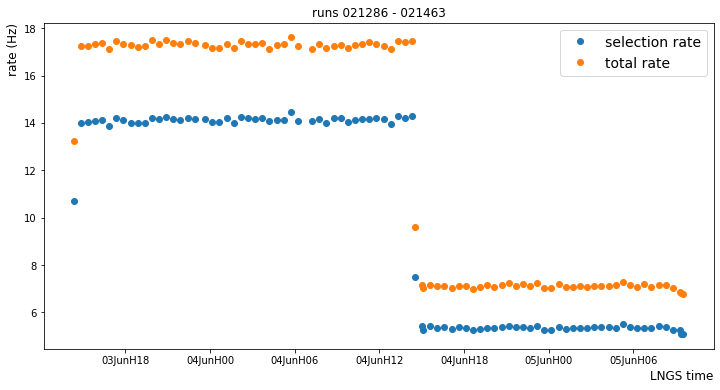

In [5]:
wcu.plot_rate_vs_time(runs,mask_rates,all_rates,times)

run 021455, start 2021-06-05 01:17:20.003368, livetime 1800.93 s, rate: 7.14 Hz, selection rate: 5.37 Hz
Drift velocity = 0.670~mm/$\mu$s
Diffusion constant = 50.13 +/- inf cm$^2$/s 


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


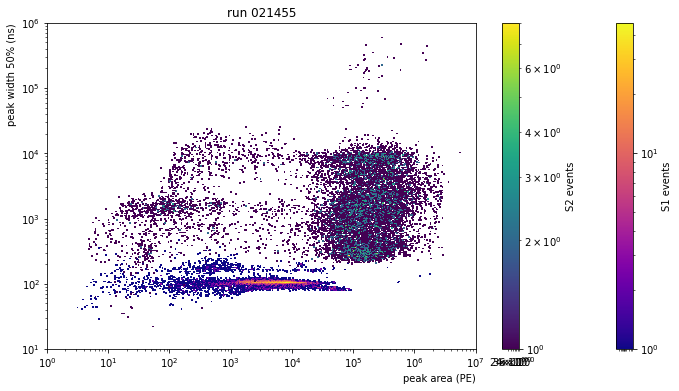

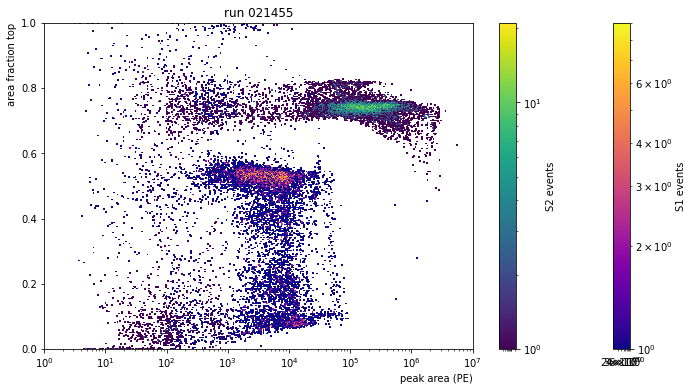

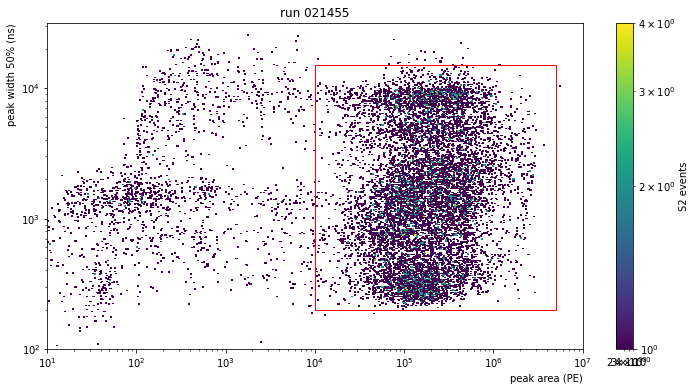

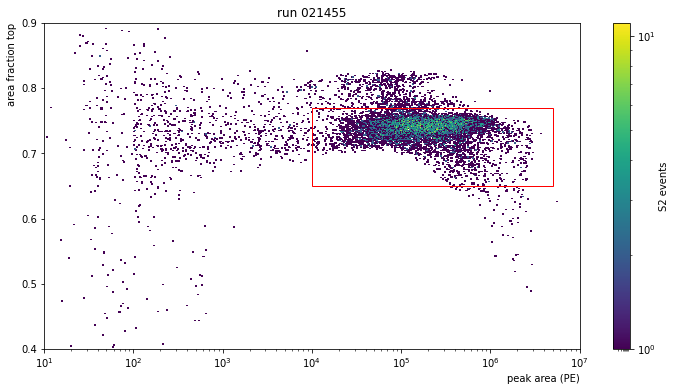

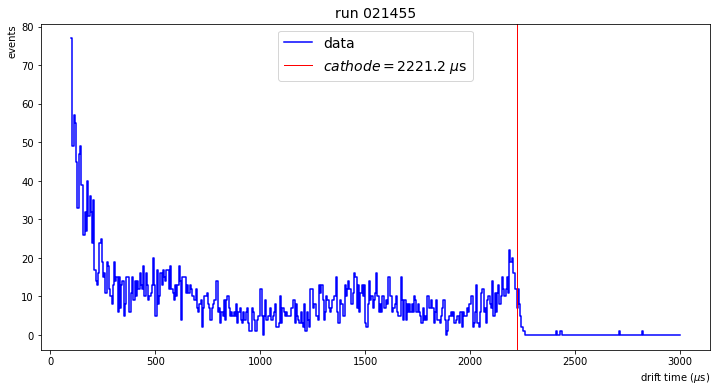

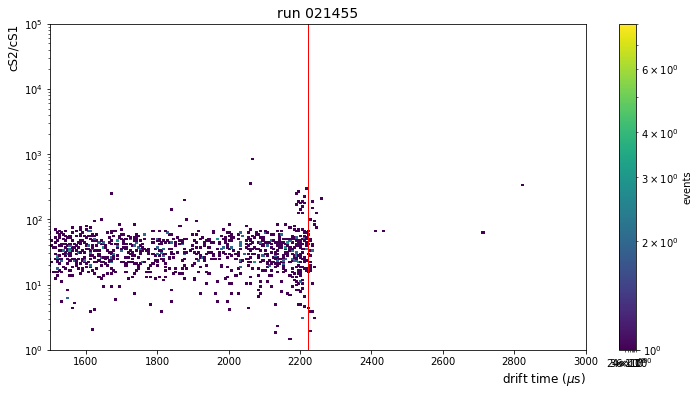

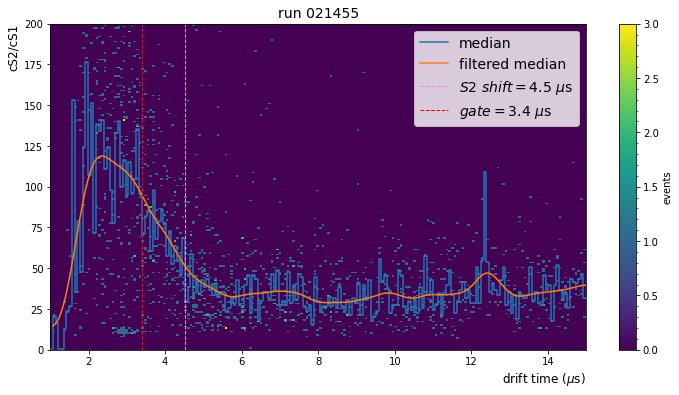

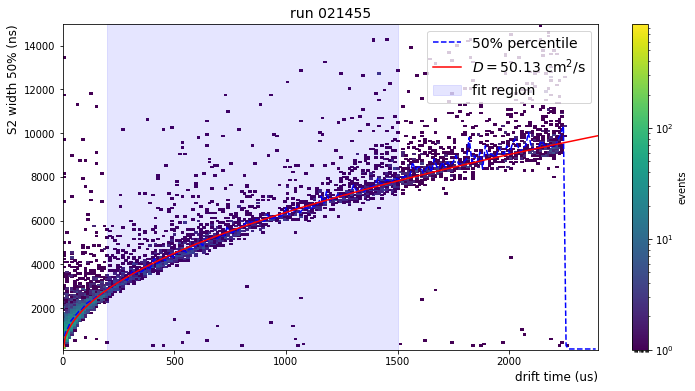

In [6]:
run, vd, vd_err, d, d_err, par, par_err = ddu.diffusion_analysis(st,AmBe_runs[4],area_cut=(1e4,5e6),fit_range=(1,1500), plot = True)

In [7]:
AmBe_events = wcu.merge_runs(st,AmBe_runs)

Reading runs from 021286 to 021463
n. 4 run 021453 elapsed time: 0.69 s
n. 9 run 021443 elapsed time: 1.84 s
n. 14 run 021433 elapsed time: 3.40 s
n. 19 run 021423 elapsed time: 4.81 s
n. 24 run 021413 elapsed time: 6.50 s
n. 29 run 021403 elapsed time: 8.75 s
n. 34 run 021393 elapsed time: 11.26 s
n. 39 run 021383 elapsed time: 14.16 s
n. 44 run 021373 elapsed time: 17.46 s
n. 49 run 021363 elapsed time: 21.91 s
n. 54 run 021353 elapsed time: 27.32 s
n. 59 run 021341 elapsed time: 34.06 s
n. 64 run 021331 elapsed time: 41.65 s
n. 69 run 021320 elapsed time: 50.01 s
n. 74 run 021310 elapsed time: 59.24 s
n. 79 run 021300 elapsed time: 69.37 s
n. 84 run 021290 elapsed time: 80.45 s


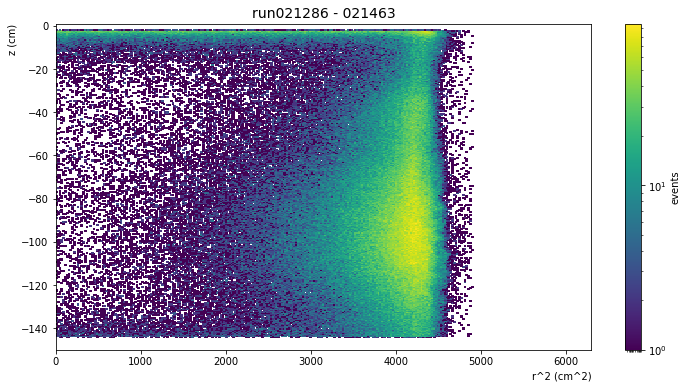

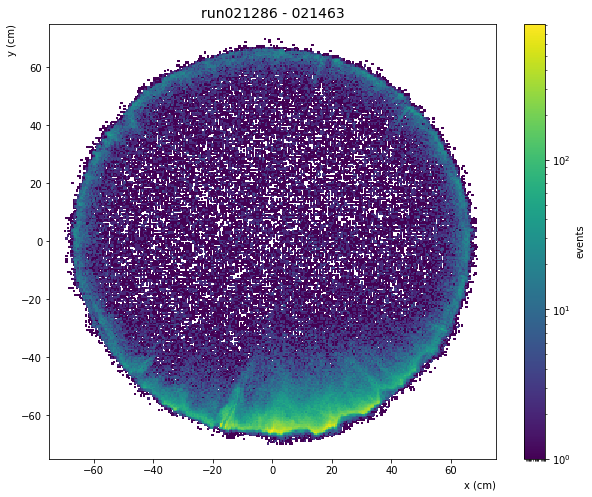

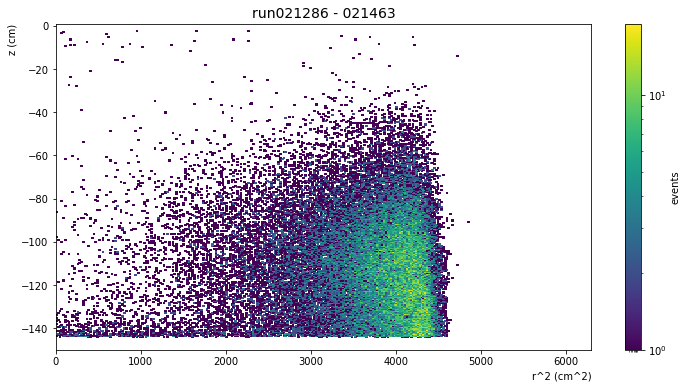

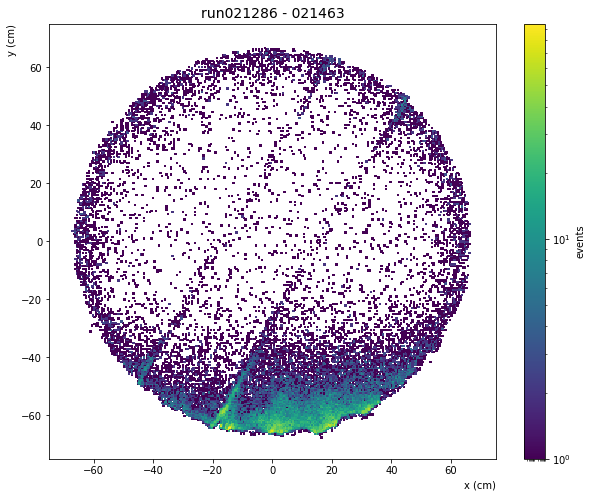

In [8]:
wcu.plot_r2_z(AmBe_events[wcu.basic_cuts(AmBe_events)],AmBe_runs)
wcu.plot_r2_z(AmBe_events[(wcu.basic_cuts(AmBe_events)) & (AmBe_events['s2_area']>5e4)
                 & (AmBe_events['s2_range_50p_area']>1e4)],AmBe_runs)

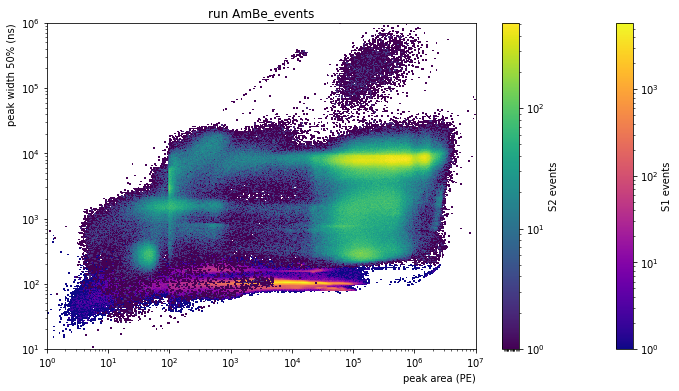

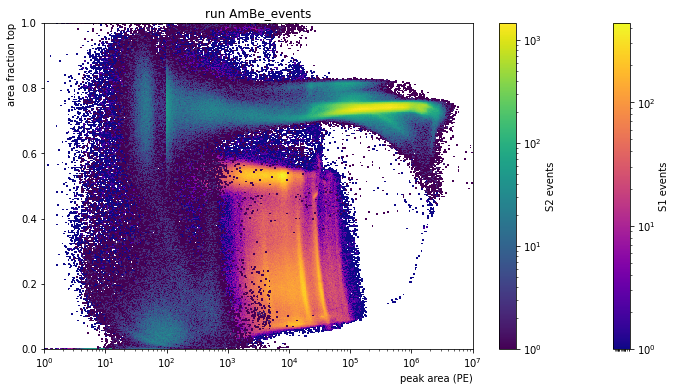

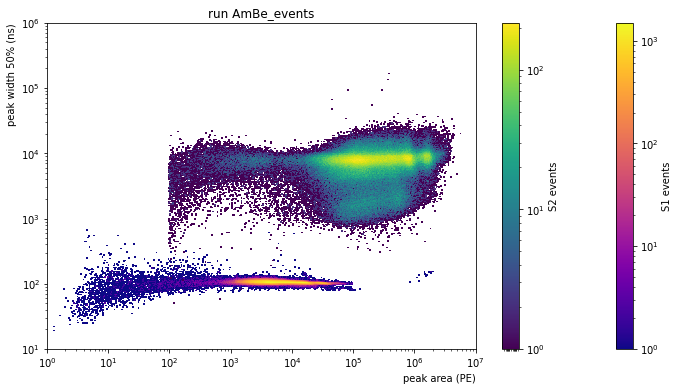

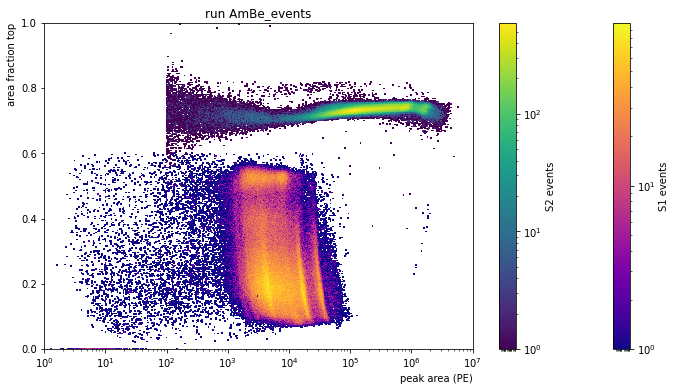

In [9]:
ddu.plot_area_width_aft(AmBe_events,'AmBe_events', low = 0, high = 7, low2 = 0, high2 = 1, binning = 500)
ddu.plot_area_width_aft(AmBe_events[wcu.basic_cuts(AmBe_events,aft_cut=0)],'AmBe_events', low = 0, high = 7, low2 = 0, high2 = 1, binning = 500)

/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/multihist.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bin_edges = np.array(bin_edges)
/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/multihist.py:449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([self.bin_centers(axis=i) for i in range(self.dimensions)])


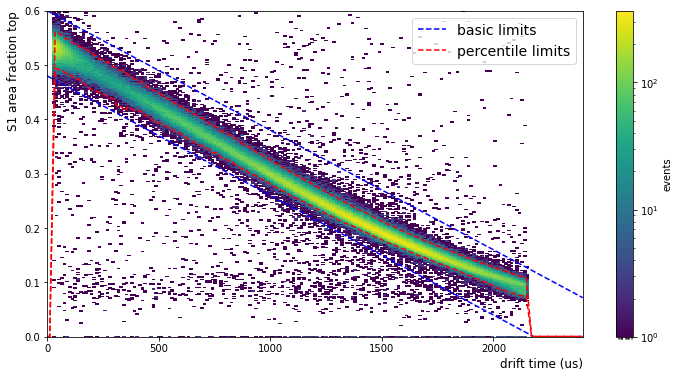

In [10]:
aft_cut = wcu.S1AFT_cut(AmBe_events, basic_cut=1, plot=1,prc=2 )

/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/multihist.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bin_edges = np.array(bin_edges)
/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/multihist.py:449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([self.bin_centers(axis=i) for i in range(self.dimensions)])
/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings

total events 1922150 selected events 133568


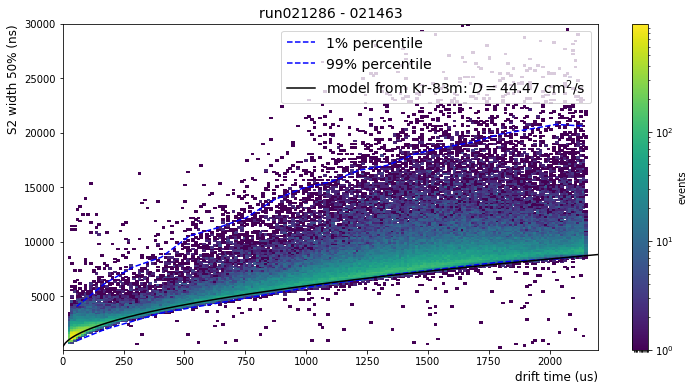

In [11]:
S2WidthCut_basic = wcu.S2WidthCut_basic(AmBe_events,AmBe_runs,mod_par=(44.47,0.676,375), perc=(1,99),
                                        FVcut = (-144,-2,3700), S1AFTcut = 2, plot=1)

/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/multihist.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bin_edges = np.array(bin_edges)
/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/multihist.py:449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([self.bin_centers(axis=i) for i in range(self.dimensions)])


total events 1922150 selected events 412660


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/multihist.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bin_edges = np.array(bin_edges)
/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/multihist.py:449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array

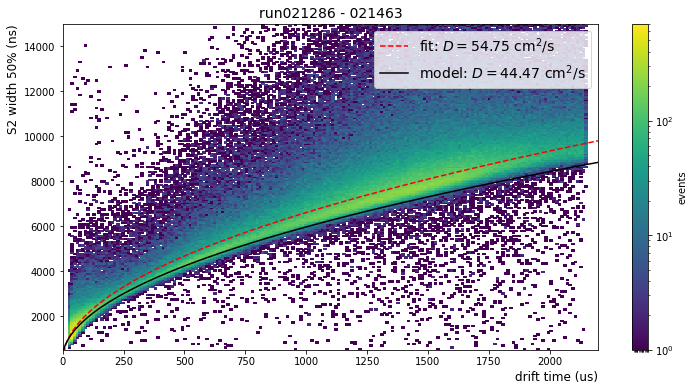

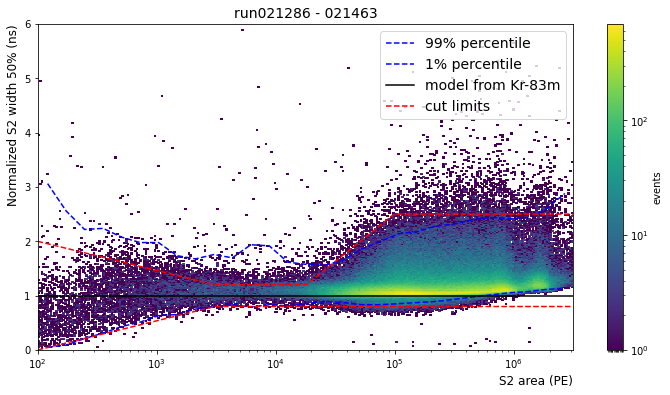

In [12]:
S2WidthCut = wcu.S2WidthCut_percentile(AmBe_events,AmBe_runs,mod_par=(44.47,0.676,375), perc=(1,99),
                                       FVcut=(-144,-2,5000), S1AFTcut = 2, delta=0.2, dlarge=1.5, plot=1)

In [13]:
ev1 = AmBe_events[wcu.basic_cuts(AmBe_events)]
ev2 = AmBe_events[wcu.basic_cuts(AmBe_events)&S2WidthCut_basic]
ev3 = AmBe_events[wcu.basic_cuts(AmBe_events)&S2WidthCut]
print('Total events',len(AmBe_events))
print('Events after basic cuts',len(ev1), len(ev1)/len(AmBe_events)*100)
print('Events after basic cuts & simple S2WidthCut',len(ev2), len(ev2)/len(ev1)*100)
print('Events after basic cuts & prel S2WidthCut',len(ev3), len(ev3)/len(ev1)*100)

Total events 1922150
Events after basic cuts 429702 22.355279244595895
Events after basic cuts & simple S2WidthCut 420077 97.76007558726747
Events after basic cuts & prel S2WidthCut 423113 98.46661174488366


In [14]:
wcu.display_events_S2WidthCut(st,AmBe_runs[4], nev = 10, s2_width_cut = True)

run 021455, start 2021-06-05 01:17:20.003368, livetime 1800.93 s, rate: 7.14 Hz, selection rate: 0.16 Hz
total events 12864 selected events 1635
events before width cut 89 events after selection 86 no width cut 3


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/multihist.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bin_edges = np.array(bin_edges)
/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/multihist.py:449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([self.bin_centers(axis=i) for i in range(self.dimensions)])


Loading BokehJS ...

/dali/lgrandi/strax/straxen/straxen/analyses/bokeh_waveform_plot.py:561: RuntimeWarning: divide by zero encountered in log10
  area_plot = np.log10(area_per_channel)


/dali/lgrandi/strax/straxen/straxen/analyses/bokeh_waveform_plot.py:561: RuntimeWarning: divide by zero encountered in log10
  area_plot = np.log10(area_per_channel)


In [15]:
wcu.display_events_S2WidthCut(st,AmBe_runs[4], nev = 3, s2_width_cut = False)

run 021455, start 2021-06-05 01:17:20.003368, livetime 1800.93 s, rate: 7.14 Hz, selection rate: 0.16 Hz
total events 12864 selected events 1635
events before width cut 89 events after selection 86 no width cut 3


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/multihist.py:329: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bin_edges = np.array(bin_edges)
/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/multihist.py:449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([self.bin_centers(axis=i) for i in range(self.dimensions)])


In [ ]:
wcu.display_events_S2WidthCut(st,AmBe_runs[5], nev = 1, area_cut=(1e6,5e7), s2_width_cut = True)